In [18]:
import sys
sys.path.insert(0, "../src")

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import sys
if '..' not in sys.path:
    sys.path.append('..')

from boo_nn import NeuralNetwork, train_neural_network, evaluate_neural_network
from autoencoder_gmm import AutoencoderGMM
from probabilistic_model import ProbabilisticModel

np.random.seed(1)

In [19]:
state_labels = {
    'hda': 0,
    'lda': 1,
    'liquid': 2,
    'ice': 2
}

def load_data(model, feat='all', size=16, states=['hda', 'lda']):
    ''' Method for efficiently loading environments for a given number of neighbors. '''
    desc_dir = '..'
    descs = []
    labels = []
    for state in states:
        if feat == 'stein':
            stein = np.load(f'{desc_dir}/data/descriptors/neigh_{size}/{model}_{state}_stein.npy')
            descs.append(stein)
            for _ in range(stein.shape[0]):
                labels.append(state_labels[state])
        elif feat == 'acsf':
            acsf = np.load(f'{desc_dir}/data/descriptors/neigh_{size}/{model}_{state}_acsf.npy')
            descs.append(acsf)
            for _ in range(acsf.shape[0]):
                labels.append(state_labels[state])
        elif feat == 'all':
            acsf = np.load(f'{desc_dir}/data/descriptors/neigh_{size}/{model}_{state}_acsf.npy')
            stein = np.load(f'{desc_dir}/data/descriptors/neigh_{size}/{model}_{state}_stein.npy')
            desc = np.hstack((acsf, stein))
            descs.append(desc)
            for _ in range(desc.shape[0]):
                labels.append(state_labels[state])
    desc = np.vstack(descs)
    labels = np.array(labels)
    return desc, labels

In [20]:
# Specify water model (either 'scan' or 'mbpol').
MODEL = 'mbpol'

# Save probabilites for outlier detection analysis.
probabilities = {
    'boo-nn': {'hda': [], 'lda': []},
    'pointnet': {'hda': [], 'lda': []},
    'ae-gmm': {'hda': [], 'lda': []},
    'ours': {'hda': [], 'lda': []},
}
ice_probabilities = {
    'boo-nn': {'hda': [], 'lda': []},
    'pointnet': {'hda': [], 'lda': []},
    'ae-gmm': {'hda': [], 'lda': []},
    'ours': {'hda': [], 'lda': []},
}

In [4]:
# Prepare datasets for BOO-NN.
X, y = load_data(model=MODEL, feat='stein')
hda_idx = np.argwhere(y == 0).reshape(-1)
lda_idx = np.argwhere(y == 1).reshape(-1)

# Convert labels to one-hot encoding.
y_ohe = np.zeros((y.shape[0], 2), dtype=np.int32)
for y_idx, y_class in enumerate(y):
    y_ohe[y_idx,y_class] = 1
y = y_ohe

# Assess classification accuracy for BOO-NN.
metrics = {
    'hda_precisions': [],
    'lda_precisions': [],
    'hda_recalls': [],
    'lda_recalls': [],
    'accuracies': []
}
kf = KFold(n_splits=5, shuffle=True, random_state=1)
for idx, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f'Evaluating fold {idx + 1} / 5.')
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]
    model = NeuralNetwork(in_dim=X_train.shape[1], n_classes=2)
    train_neural_network(model, X_train, y_train)
    _, probs = evaluate_neural_network(model, X_test, prob=True)

    # Save probabilities for true configurations for subsequent analysis.
    lda_idx = np.argwhere(np.argmax(y_test, axis=1) == 1).reshape(-1) 
    hda_idx = np.argwhere(np.argmax(y_test, axis=1) == 0).reshape(-1) 
    lda_probs = probs[lda_idx, 1]
    hda_probs = probs[hda_idx, 0]
    probabilities['boo-nn']['lda'].append(lda_probs)
    probabilities['boo-nn']['hda'].append(hda_probs)
    y_pred = np.argmax(probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Save performance metrics.
    conf_mat = confusion_matrix(y_true, y_pred)
    metrics['hda_precisions'].append(conf_mat[0,0] / (conf_mat[1,0] + conf_mat[0,0]))
    metrics['lda_precisions'].append(conf_mat[1,1] / (conf_mat[0,1] + conf_mat[1,1]))
    metrics['hda_recalls'].append(conf_mat[0,0] / (conf_mat[0,1] + conf_mat[0,0]))
    metrics['lda_recalls'].append(conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1]))
    metrics['accuracies'].append((conf_mat[0,0] + conf_mat[1,1]) / np.sum(conf_mat, axis=(0,1)))

# Report accuracy metrics.
print(f'HDA Precision: {np.mean(metrics["hda_precisions"]):.3f} +/- {np.std(metrics["hda_precisions"]):.3f}')
print(f'LDA Precision: {np.mean(metrics["lda_precisions"]):.3f} +/- {np.std(metrics["lda_precisions"]):.3f}')
print(f'HDA Recall: {np.mean(metrics["hda_recalls"]):.3f} +/- {np.std(metrics["hda_recalls"]):.3f}')
print(f'LDA Recall: {np.mean(metrics["lda_recalls"]):.3f} +/- {np.std(metrics["lda_recalls"]):.3f}')
print(f'Accuracy: {np.mean(metrics["accuracies"]):.3f} +/- {np.std(metrics["accuracies"]):.3f}')

Evaluating fold 1 / 5.
Evaluating fold 2 / 5.
Evaluating fold 3 / 5.
Evaluating fold 4 / 5.
Evaluating fold 5 / 5.
HDA Precision: 0.997 +/- 0.001
LDA Precision: 0.997 +/- 0.002
HDA Recall: 0.997 +/- 0.002
LDA Recall: 0.997 +/- 0.001
Accuracy: 0.997 +/- 0.001


In [5]:
# Retrain BOO-NN model on all HDA, LDA, and liquid configurations.
model = NeuralNetwork(in_dim=X.shape[1], n_classes=2)
train_neural_network(model, X, y)

# Evaluate trained BOO-NN when extrapolating to hexagonal ice structures.
X_ice = np.load(f'../data/descriptors/neigh_16/{MODEL}_ice_stein.npy')
y_ice, prob_ice = evaluate_neural_network(model, X_ice, prob=True)
ice_probabilities['boo-nn']['hda'] = prob_ice[:,0]
ice_probabilities['boo-nn']['lda'] = prob_ice[:,1]

In [6]:
# Load PointNet data.
probabilities['pointnet']['hda'] = np.load(f'./data/{MODEL}_pointnet_hda_prob.npy')
probabilities['pointnet']['lda'] = np.load(f'./data/{MODEL}_pointnet_lda_prob.npy')
ice_probabilities['pointnet']['hda'] = np.load(f'./data/{MODEL}_pointnet_ice_hda_prob.npy')
ice_probabilities['pointnet']['lda'] = np.load(f'./data/{MODEL}_pointnet_ice_lda_prob.npy')

In [7]:
# Prepare datasets for AE-GMM.
X, y = load_data(model=MODEL, feat='stein', states=['hda', 'lda'])
hda_idx = np.argwhere(y == 0).reshape(-1)
lda_idx = np.argwhere(y == 1).reshape(-1)

# Get a train/test split.
metrics = {
    'hda_precisions': [],
    'lda_precisions': [],
    'hda_recalls': [],
    'lda_recalls': [],
    'accuracies': []
}
prob_lda = []
kf = KFold(n_splits=5, shuffle=True, random_state=1)
for idx, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f'Evaluating fold {idx + 1} / 5.')
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]
    model = AutoencoderGMM(input_dim=X.shape[1], latent_dim=2, num_classes=2)
    model.fit(X_train, y_train, max_epochs=20)
    y_pred, probs = model.predict(X_test, prob=True)

    # Save probabilities for true configurations for subsequent analysis.
    lda_idx = np.argwhere(y_test == 1).reshape(-1) 
    hda_idx = np.argwhere(y_test == 0).reshape(-1) 
    lda_probs = probs[lda_idx, 1]
    hda_probs = probs[hda_idx, 0]
    probabilities['ae-gmm']['lda'].append(lda_probs)
    probabilities['ae-gmm']['hda'].append(hda_probs)      
    y_pred = np.argmax(probs, axis=1)

    # Save performance metrics.
    conf_mat = confusion_matrix(y_test, y_pred)
    metrics['hda_precisions'].append(conf_mat[0,0] / (conf_mat[1,0] + conf_mat[0,0]))
    metrics['lda_precisions'].append(conf_mat[1,1] / (conf_mat[0,1] + conf_mat[1,1]))
    metrics['hda_recalls'].append(conf_mat[0,0] / (conf_mat[0,1] + conf_mat[0,0]))
    metrics['lda_recalls'].append(conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1]))
    metrics['accuracies'].append((conf_mat[0,0] + conf_mat[1,1]) / np.sum(conf_mat, axis=(0,1)))

# Report accuracy metrics.
print(f'HDA Precision: {np.mean(metrics["hda_precisions"]):.3f} +/- {np.std(metrics["hda_precisions"]):.3f}')
print(f'LDA Precision: {np.mean(metrics["lda_precisions"]):.3f} +/- {np.std(metrics["lda_precisions"]):.3f}')
print(f'HDA Recall: {np.mean(metrics["hda_recalls"]):.3f} +/- {np.std(metrics["hda_recalls"]):.3f}')
print(f'LDA Recall: {np.mean(metrics["lda_recalls"]):.3f} +/- {np.std(metrics["lda_recalls"]):.3f}')
print(f'Accuracy: {np.mean(metrics["accuracies"]):.3f} +/- {np.std(metrics["accuracies"]):.3f}')

Evaluating fold 1 / 5.
Epoch 1 | Train loss = 0.00565787 | Val loss =  0.00556715 | Rate = 0.001000
Epoch 2 | Train loss = 0.00536808 | Val loss =  0.00555717 | Rate = 0.001000
Epoch 3 | Train loss = 0.00535735 | Val loss =  0.00553684 | Rate = 0.001000
Epoch 4 | Train loss = 0.00533838 | Val loss =  0.00552814 | Rate = 0.001000
Epoch 5 | Train loss = 0.00531869 | Val loss =  0.00550216 | Rate = 0.001000
Epoch 6 | Train loss = 0.00529177 | Val loss =  0.00547560 | Rate = 0.001000
Epoch 7 | Train loss = 0.00526432 | Val loss =  0.00545780 | Rate = 0.001000
Epoch 8 | Train loss = 0.00523388 | Val loss =  0.00541774 | Rate = 0.001000
Epoch 9 | Train loss = 0.00521878 | Val loss =  0.00541301 | Rate = 0.001000
Epoch 10 | Train loss = 0.00520549 | Val loss =  0.00538573 | Rate = 0.001000
Epoch 11 | Train loss = 0.00519552 | Val loss =  0.00538071 | Rate = 0.001000
Epoch 12 | Train loss = 0.00518989 | Val loss =  0.00537873 | Rate = 0.001000
Epoch 13 | Train loss = 0.00518399 | Val loss =  0

In [9]:
# Retrain AE-GMM model on all HDA, LDA, and liquid configurations.
model = AutoencoderGMM(input_dim=X.shape[1], latent_dim=2, num_classes=2)
model.fit(X, y, max_epochs=20)

# Evaluate trained AE-GMM when extrapolating to hexagonal ice structures.
X_ice = np.load(f'../data/descriptors/neigh_16/{MODEL}_ice_stein.npy')
y_pred, prob_ice = model.predict(X_ice, prob=True)
ice_probabilities['ae-gmm']['hda'] = prob_ice[:,0]
ice_probabilities['ae-gmm']['lda'] = prob_ice[:,1]

Epoch 1 | Train loss = 0.00554428 | Val loss =  0.00551096 | Rate = 0.001000
Epoch 2 | Train loss = 0.00534806 | Val loss =  0.00547527 | Rate = 0.001000
Epoch 3 | Train loss = 0.00532525 | Val loss =  0.00546505 | Rate = 0.001000
Epoch 4 | Train loss = 0.00529850 | Val loss =  0.00542263 | Rate = 0.001000
Epoch 5 | Train loss = 0.00526191 | Val loss =  0.00539122 | Rate = 0.001000
Epoch 6 | Train loss = 0.00522549 | Val loss =  0.00536223 | Rate = 0.001000
Epoch 7 | Train loss = 0.00519498 | Val loss =  0.00533496 | Rate = 0.001000
Epoch 8 | Train loss = 0.00518352 | Val loss =  0.00533539 | Rate = 0.001000
Epoch 9 | Train loss = 0.00517209 | Val loss =  0.00532105 | Rate = 0.001000
Epoch 10 | Train loss = 0.00515943 | Val loss =  0.00528979 | Rate = 0.001000
Epoch 11 | Train loss = 0.00515922 | Val loss =  0.00530972 | Rate = 0.001000
Epoch 12 | Train loss = 0.00515565 | Val loss =  0.00530088 | Rate = 0.001000
Epoch 13 | Train loss = 0.00514691 | Val loss =  0.00529541 | Rate = 0.00

In [21]:
# Prepare training set for our model.
MODEL = 'mbpol'
X, y = load_data(model=MODEL, feat='all')
hda_idx = np.argwhere(y == 0).reshape(-1)
lda_idx = np.argwhere(y == 1).reshape(-1)

# Assess classification accuracy for our model.
metrics = {
    'hda_precisions': [],
    'lda_precisions': [],
    'hda_recalls': [],
    'lda_recalls': [],
    'accuracies': []
}
prob_lda = []
kf = KFold(n_splits=5, shuffle=True, random_state=1)
for idx, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f'Evaluating fold {idx + 1} / 5.')
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]
    model = ProbabilisticModel(
        max_features=5, 
        include=0.98,
        detect_outliers=False,
        corr_cut=0.8,
        use_features=[0]
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test, binary=True)   # Only consider HDA/LDA predictions.
    log_probs = model.get_log_prob(X_test, binary=True) # Only consider HDA/LDA predictions.
    probs = np.exp(log_probs)

    # Save probabilities for true configurations for subsequent analysis.
    lda_idx = np.argwhere(y_test == 1).reshape(-1) 
    hda_idx = np.argwhere(y_test == 0).reshape(-1) 
    lda_probs = probs[lda_idx, 1]
    hda_probs = probs[hda_idx, 0]
    probabilities['ours']['lda'].append(lda_probs)
    probabilities['ours']['hda'].append(hda_probs)
    
    # Save performance metrics.
    valid_idx = np.argwhere(y_pred != -1).reshape(-1)
    conf_mat = confusion_matrix(y_test[valid_idx], y_pred[valid_idx])
    metrics['hda_precisions'].append(conf_mat[0,0] / (conf_mat[1,0] + conf_mat[0,0]))
    metrics['lda_precisions'].append(conf_mat[1,1] / (conf_mat[0,1] + conf_mat[1,1]))
    metrics['hda_recalls'].append(conf_mat[0,0] / (conf_mat[0,1] + conf_mat[0,0]))
    metrics['lda_recalls'].append(conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1]))
    metrics['accuracies'].append((conf_mat[0,0] + conf_mat[1,1]) / np.sum(conf_mat, axis=(0,1)))

# Report accuracy metrics.
print(f'HDA Precision: {np.mean(metrics["hda_precisions"]):.3f} +/- {np.std(metrics["hda_precisions"]):.3f}')
print(f'LDA Precision: {np.mean(metrics["lda_precisions"]):.3f} +/- {np.std(metrics["lda_precisions"]):.3f}')
print(f'HDA Recall: {np.mean(metrics["hda_recalls"]):.3f} +/- {np.std(metrics["hda_recalls"]):.3f}')
print(f'LDA Recall: {np.mean(metrics["lda_recalls"]):.3f} +/- {np.std(metrics["lda_recalls"]):.3f}')
print(f'Accuracy: {np.mean(metrics["accuracies"]):.3f} +/- {np.std(metrics["accuracies"]):.3f}')

Evaluating fold 1 / 5.
Evaluating fold 2 / 5.
Evaluating fold 3 / 5.
Evaluating fold 4 / 5.
Evaluating fold 5 / 5.
HDA Precision: 0.986 +/- 0.002
LDA Precision: 0.987 +/- 0.003
HDA Recall: 0.987 +/- 0.003
LDA Recall: 0.986 +/- 0.002
Accuracy: 0.987 +/- 0.001


In [15]:
# Retrain our model on all HDA, LDA, and liquid configurations.
model = ProbabilisticModel(
    max_features=5, 
    include=0.98,
    detect_outliers=False,
    corr_cut=0.8,
    # use_features=[0, 123, 104, 105, 122]
)
model.fit(X, y)

# Evaluate trained model when extrapolating to hexagonal ice structures.
X_ice_acsf = np.load(f'../data/descriptors/neigh_16/{MODEL}_ice_acsf.npy')
X_ice_stein = np.load(f'../data/descriptors/neigh_16/{MODEL}_ice_stein.npy')
X_ice = np.hstack((X_ice_acsf, X_ice_stein))
log_prob_ice = model.get_log_prob(X_ice, binary=True)
prob_ice = np.exp(log_prob_ice)
ice_probabilities['ours']['hda'] = prob_ice[:,0]
ice_probabilities['ours']['lda'] = prob_ice[:,1]

In [16]:
# Aggregate predictions across folds.
for model in probabilities.keys():
    for state in probabilities[model].keys():
        if len(probabilities[model][state]) > 0:
            probabilities[model][state] = np.hstack((probabilities[model][state]))

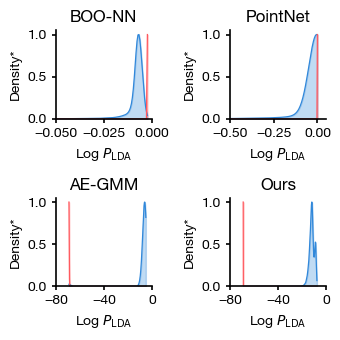

In [17]:
from scipy.stats import gaussian_kde
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['axes.linewidth'] = 1.2

COLORS = ['#FF5A5F', "#3188DA"]
STATE = 'lda'
X_LABEL = 'Log ' + r'$P_{\text{LDA}}$'

fig, axs = plt.subplots(2,2,figsize=(3.5,3.5))

# Plot results for BOO-NN.
state_probs = probabilities['boo-nn'][STATE]
ice_probs = ice_probabilities['boo-nn'][STATE]
state_probs = state_probs + 1e-30
ice_probs = ice_probs + 1e-30
state_log_probs = np.log(state_probs)
ice_log_probs = np.log(ice_probs)

# For better smoothing of the KDE.
state_log_probs_plot = state_log_probs[np.argwhere(state_log_probs > -0.1).reshape(-1)]
ice_log_probs_plot = ice_log_probs[np.argwhere(ice_log_probs > -0.1).reshape(-1)]

x = np.linspace(
    min(np.min(state_log_probs_plot), np.min(ice_log_probs_plot)), 
    max(np.max(state_log_probs_plot), np.max(ice_log_probs_plot)), 
    200
)
lda_kde = gaussian_kde(state_log_probs_plot)
y_lda = lda_kde(x)
y_lda /= y_lda.max()
ice_kde = gaussian_kde(ice_log_probs_plot)
y_ice = ice_kde(x)
y_ice /= y_ice.max()
axs[0,0].plot(x, y_lda, color=COLORS[1], linewidth=0.9)
axs[0,0].fill_between(x, y_lda, alpha=0.3, color=COLORS[1])
axs[0,0].plot(x, y_ice, color=COLORS[0], linewidth=0.9)
axs[0,0].fill_between(x, y_ice, alpha=0.3, color=COLORS[0])
if STATE == 'lda':
    axs[0,0].set_xlim(xmin=-0.05, xmax=0.0)
    axs[0,0].set_xticks(ticks=[-0.05, -0.025, 0.0])
else:
    axs[0,0].set_xlim(xmin=-8.0, xmax=0.0)
axs[0,0].set_ylim(ymin=0.0, ymax=1.05)
axs[0,0].set_xlabel(X_LABEL)
axs[0,0].set_ylabel('Density*')
axs[0,0].set_yticks(ticks=[0.0, 0.5, 1.0])
axs[0,0].tick_params(axis='both', width=1.2, length=3.0)
axs[0,0].spines[['top', 'right']].set_visible(False)
axs[0,0].set_title('BOO-NN')

# Plot results for PointNet.
state_probs = probabilities['pointnet'][STATE]
ice_probs = ice_probabilities['pointnet'][STATE]
state_probs = state_probs + 1e-30
ice_probs = ice_probs + 1e-30
state_log_probs = np.log(state_probs)
ice_log_probs = np.log(ice_probs)

# For better smoothing of the KDE.
state_log_probs_plot = state_log_probs[np.argwhere(state_log_probs > -0.5).reshape(-1)]
ice_log_probs_plot = ice_log_probs[np.argwhere(ice_log_probs > -0.5).reshape(-1)]

x = np.linspace(
    min(np.min(state_log_probs_plot), np.min(ice_log_probs_plot)), 
    max(np.max(state_log_probs_plot), np.max(ice_log_probs_plot)), 
    200
)
lda_kde = gaussian_kde(state_log_probs)
y_lda = lda_kde(x)
y_lda /= y_lda.max()
ice_kde = gaussian_kde(ice_log_probs)
y_ice = ice_kde(x)
y_ice /= y_ice.max()
axs[0,1].plot(x, y_lda, color=COLORS[1], linewidth=0.9)
axs[0,1].fill_between(x, y_lda, alpha=0.3, color=COLORS[1])
axs[0,1].plot(x, y_ice, color=COLORS[0], linewidth=0.9)
axs[0,1].fill_between(x, y_ice, alpha=0.3, color=COLORS[0])
if STATE == 'lda':
    axs[0,1].set_xlim(xmin=-0.5, xmax=0.05)
    axs[0,1].set_xticks(ticks=[-0.5, -0.25, 0.0])
else:
    axs[0,1].set_xlim(xmin=-15.0, xmax=0.0)
axs[0,1].set_ylim(ymin=0.0, ymax=1.05)
axs[0,1].set_xlabel(X_LABEL)
axs[0,1].set_ylabel('Density*')
axs[0,1].set_yticks(ticks=[0.0, 0.5, 1.0])
axs[0,1].tick_params(axis='both', width=1.2, length=3.0)
axs[0,1].spines[['top', 'right']].set_visible(False)
axs[0,1].set_title('PointNet')

# Plot results for AE-GMM.
state_probs = probabilities['ae-gmm'][STATE]
ice_probs = ice_probabilities['ae-gmm'][STATE]
state_probs = state_probs + 1e-30
ice_probs = ice_probs + 1e-30
state_log_probs = np.log(state_probs)
ice_log_probs = np.log(ice_probs)
x = np.linspace(
    min(np.min(state_log_probs), np.min(ice_log_probs)), 
    max(np.max(state_log_probs), np.max(ice_log_probs)), 
    2000
)
lda_kde = gaussian_kde(state_log_probs)
y_lda = lda_kde(x)
y_lda /= y_lda.max() 
axs[1,0].plot(x, y_lda, color=COLORS[1], linewidth=0.9)
axs[1,0].fill_between(x, y_lda, alpha=0.3, color=COLORS[1])

if STATE == 'lda':
    ice_kde = gaussian_kde(ice_log_probs)
    y_ice = ice_kde(x)
    y_ice /= y_ice.max()
    axs[1,0].plot(x, y_ice, color=COLORS[0], linewidth=0.9)
    axs[1,0].fill_between(x, y_ice, alpha=0.3, color=COLORS[0])
    axs[1,0].set_xticks(ticks=[-80, -40, 0.0])
    axs[1,0].set_xlim(xmin=-80, xmax=0.00)
else:
    x_mean = np.mean(ice_log_probs)
    axs[1,0].plot([x_mean, x_mean], [0.0, 1.0], color=COLORS[0], linewidth=0.9)
    axs[1,0].set_xlim(xmin=-75, xmax=0.0)

axs[1,0].set_ylim(ymin=0.0, ymax=1.05)
axs[1,0].set_xlabel(X_LABEL)
axs[1,0].set_ylabel('Density*')
axs[1,0].set_yticks(ticks=[0.0, 0.5, 1.0])
axs[1,0].tick_params(axis='both', width=1.2, length=3.0)
axs[1,0].spines[['top', 'right']].set_visible(False)
axs[1,0].set_title('AE-GMM')

# Plot results for our work.
state_probs = probabilities['ours'][STATE]
ice_probs = ice_probabilities['ours'][STATE]
state_probs = state_probs + 1e-30
ice_probs = ice_probs + 1e-30
state_log_probs = np.log(state_probs)
ice_log_probs = np.log(ice_probs)

x = np.linspace(
    min(np.min(state_log_probs), np.min(ice_log_probs)), 
    max(np.max(state_log_probs), np.max(ice_log_probs)), 
    2000
)
lda_kde = gaussian_kde(state_log_probs)
y_lda = lda_kde(x)
y_lda /= y_lda.max()
axs[1,1].plot(x, y_lda, color=COLORS[1], linewidth=0.9)
axs[1,1].fill_between(x, y_lda, alpha=0.3, color=COLORS[1])
if len(np.unique(ice_log_probs)) == 1:
    unique_value = np.unique(ice_log_probs)[0]
    axs[1,1].plot([unique_value, unique_value], [0.0, 1.0], color=COLORS[0])
else:
    ice_kde = gaussian_kde(ice_log_probs)
    y_ice = ice_kde(x)
    y_ice /= y_ice.max()
    axs[1,1].plot(x, y_ice, color=COLORS[0], linewidth=0.9)
    axs[1,1].fill_between(x, y_ice, alpha=0.3, color=COLORS[0])
axs[1,1].set_xlim(xmin=-80, xmax=0.0)
axs[1,1].set_ylim(ymin=0.0, ymax=1.05)
axs[1,1].set_xlabel(X_LABEL)
axs[1,1].set_xticks(ticks=[-80, -40, 0])
axs[1,1].set_ylabel('Density*')
axs[1,1].set_yticks(ticks=[0.0, 0.5, 1.0])
axs[1,1].tick_params(axis='both', width=1.2, length=3.0)
axs[1,1].spines[['top', 'right']].set_visible(False)
axs[1,1].set_title('Ours')

plt.tight_layout()
plt.savefig(f'./figures/{STATE}_log_confidences_{MODEL}.svg', dpi=1000, bbox_inches='tight')
plt.show()